#### Analisis de un amplificador clase C exitado con AM de m = 0.5.
Se busca que la salida tenga m = 1.0

Se estudiara la respuesta del amplificador con un muestreo 24 veces mas rapido que la portadora.

El tiempo de análisis para el cálculo de las componentes de la serie es de 1/Tm. 

La transferencia del transistor se define en la funcion idi(v).



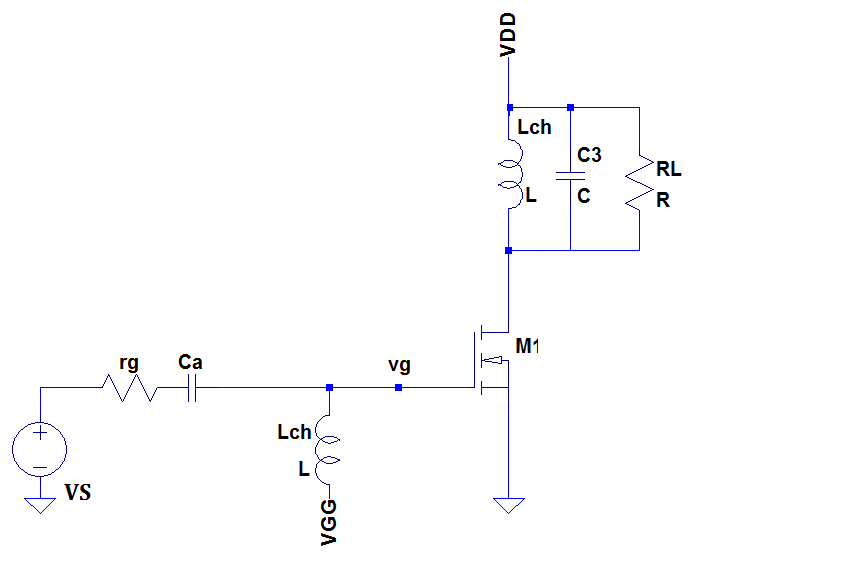

In [246]:
import numpy as np
import matplotlib.pyplot as plt
import scipy                  # http://scipy.org/
from scipy import signal

from IPython.display import Image  
%matplotlib inline
params = {'legend.fontsize': 24,
          'figure.figsize': (12, 8),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
plt.rcParams.update(params) 


Image(filename= "claseC.png",width=550)

Se definen las señales a utiilizar.

In [247]:
def myFourier(armonicos, x, y, dt, Tm):
    y_f = list()
    for a in armonicos: 
        if a == 0 : 
            yf_o = 0.0
            for i,xi in enumerate(x):
                yf_o += y[i]*dt/Tm
            y_f.append(yf_o)
        else : 
            yf_ac = 0.0
            yf_as = 0.0

            for i,xi in enumerate(x):
                yf_ac += 2.*dt/Tm * y[i]*np.cos(2*np.pi*a*xi)
                yf_as += 2.*dt/Tm * y[i]*np.sin(2*np.pi*a*xi)
            y_f.append(yf_as+yf_ac)
    return y_f

def myFourierPh(a, x, y, n):
    if a == 0 : 
        yf_o = 0.0
        for i,xi in enumerate(x):
            yf_o += y[i]*1/n
        y_f= yf_o
    else : 
        yf_ac = 0.0
        yf_as = 0.0

        for i,xi in enumerate(x):
            yf_ac += 2/n * y[i]*np.cos(a*xi)
            yf_as += 2/n * y[i]*np.sin(a*xi)
        y_f = (yf_as+yf_ac)
    return y_f

def eff(it):
    n = len(it)
    ief = (sum([i**2 for i in it])/n )**(1/2)
    return ief

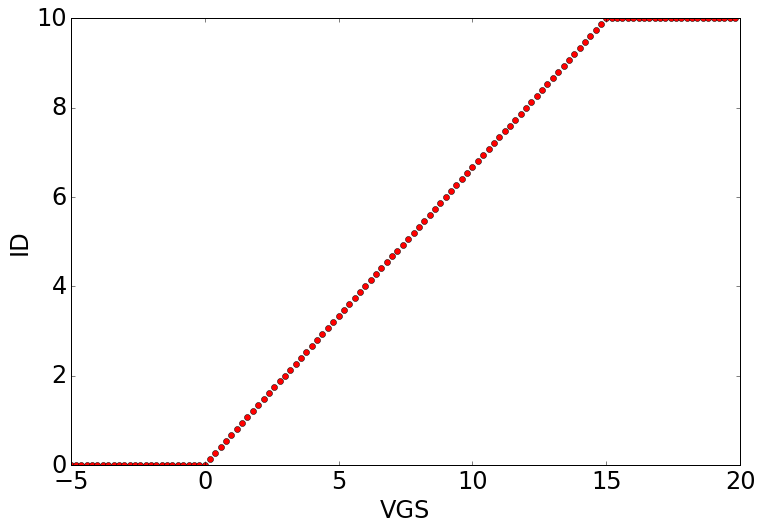

In [248]:
# filtro
def SS(vin,f, Qc, fo):
    return vin*abs(1/(1+(Qc*(f/fo-fo/f))**2)**0.5)

# transferencia del transistor
def idi(v):
    i = 0. if (v < 0.)  else 0
    i = (10./15.)*(v-0.) if (v >= 0  and v < 15) else i
    i = (10.) if (v >= 15 ) else i
    return i
vgs = np.arange(-5.,20.,0.2)

ids = []
for v in vgs:
    ids.append(idi(v))
#%matplotlib inline
#plt.gca().cla()
plt.plot(vgs,ids,'ro')
#plt.axis([-10, 10, -1, 11])
plt.ylabel('ID')
plt.xlabel('VGS')
plt.rcParams['figure.figsize'] = (20.0, 4.0)
plt.show()

In [249]:
# Para el cálculo de VGG y Vs 
# 15 = VGG + vs*(1+m) 
#  0 = VGG + vs*(1-m) 


#parametros de la senal AM
VGG = -7.5  # 
vs = 15    #amplitud de la portadora
fc = 100    #frecuencia de la portadora
m = 0.5      #indice de modulacion
fm = 2     #frecuencia de la modulante

#tiempo de un periodo de la modulante
Tm  = 1/fm

#Muestreo
fs  =  24*fc

#delta time para el calculo de los armonicos
ds  = 1/(fs)

#parametros del filtro de salida
fo = fc
BW = 2*fm*5
Qc = fo/BW

#parametros del transistor
Vgs_min = 10 
Vgs_max = 200

Respesta del transistor

Esta funcion representa la respuesta del transistor

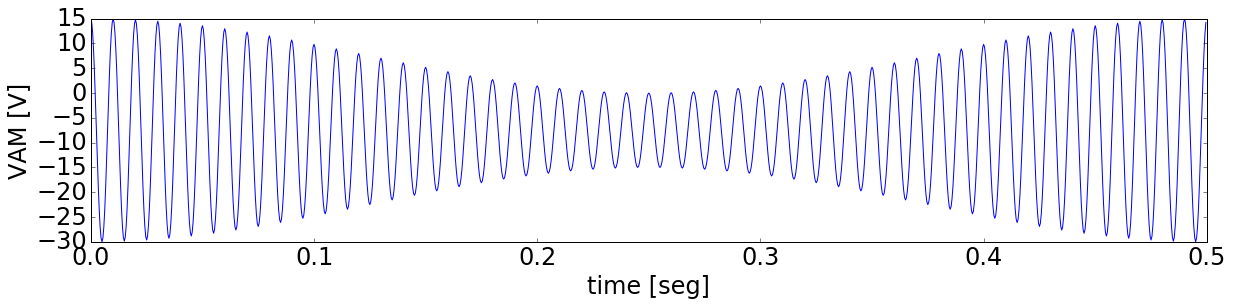

In [250]:
time = np.arange(0,Tm,ds)
vgs = []
for t in time:
    vm =  np.cos( 2*np.pi*fm*t)
    vam = vs*(1+m*(vm))*np.cos(2*np.pi*fc*t)
    vgs.append(VGG+vam)

plt.plot(time,vgs)
plt.xlabel('time [seg]')
plt.ylabel('VAM [V]')
plt.show()

Analisis de Fourier para la senal AM de entrada

In [251]:
vin_f = []

armonicos = np.arange(0,fs/2,fm)
vin_f = myFourier(armonicos, time, vgs, ds, Tm)

3.75 15.0 3.75


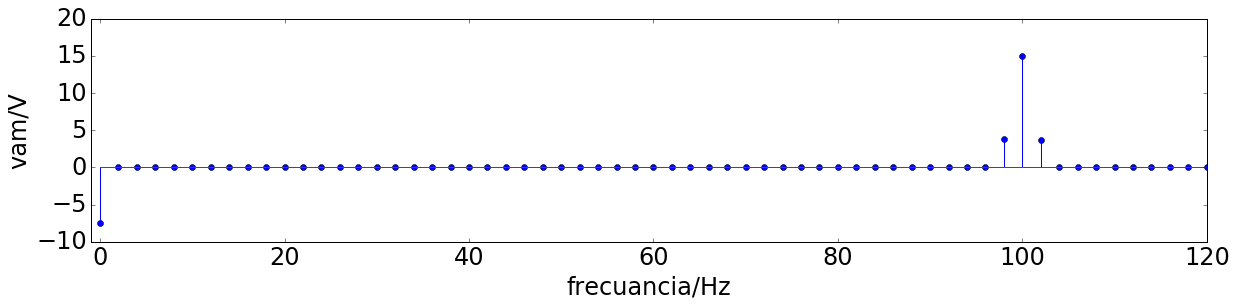

In [281]:
plt.stem(armonicos[:],vin_f[:]) 
plt.xlabel('frecuancia/Hz')
plt.ylabel('vam/V')
plt.xlim([ -1,120])
print(np.abs(vin_f[49]),np.abs(vin_f[50]),np.abs(vin_f[51]))

Corriente de salida del transistor 

Se obtinee la función temporal de id en función de vds. 

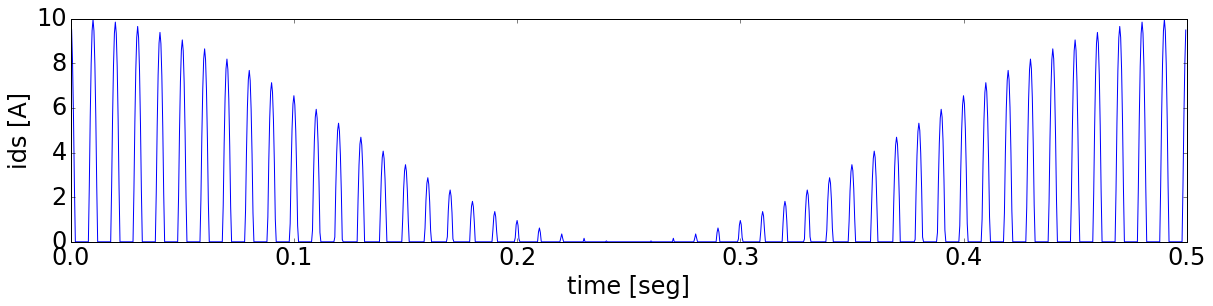

In [253]:
ids = []
for x,t in enumerate(time):
    ids.append(idi(vgs[x]))

plt.plot(time,ids)
plt.xlabel('time [seg]')
plt.ylabel('ids [A]')

Analisis de Fourier para la corriente de salida

In [254]:
ids_mf = myFourier(armonicos, time, ids, ds, Tm)

i_ef   = eff(ids)
print('Corriente eficaz de salida i_ef {:0.2f} A'.format(i_ef) )

Corriente eficaz de salida i_ef 2.69 A


1.12607958267 2.05270333235 1.12608830589


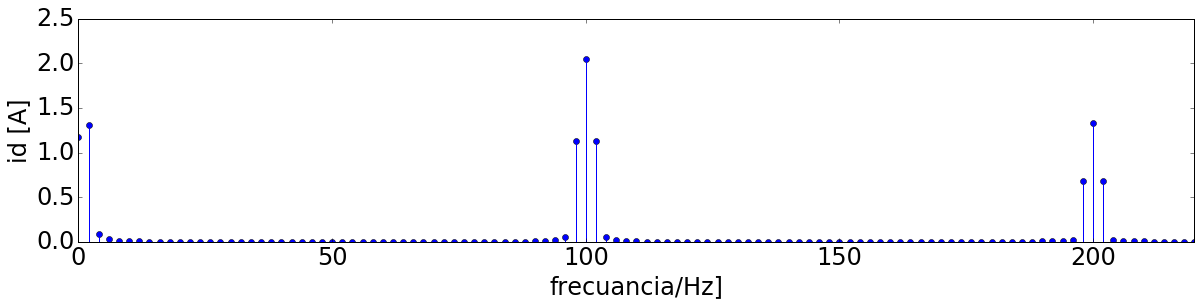

In [283]:
plt.stem(armonicos[:],np.abs(ids_mf[:]) ) 
plt.xlabel('frecuancia/Hz]')
plt.ylabel('id [A]')
plt.xlim([0,220])

print(np.abs(ids_mf[49]),np.abs(ids_mf[50]),np.abs(ids_mf[51]))

Del análisis anterior, se observa que el m del AM es mayor que el de la entrada.

Vo(98) =23.92 V, Vo(100) =44.49 V,Vo(102) =23.94 V
Pinf =13.20 W, Pcar =45.66 W, Psup =13.22 W
PAM =72.09 W


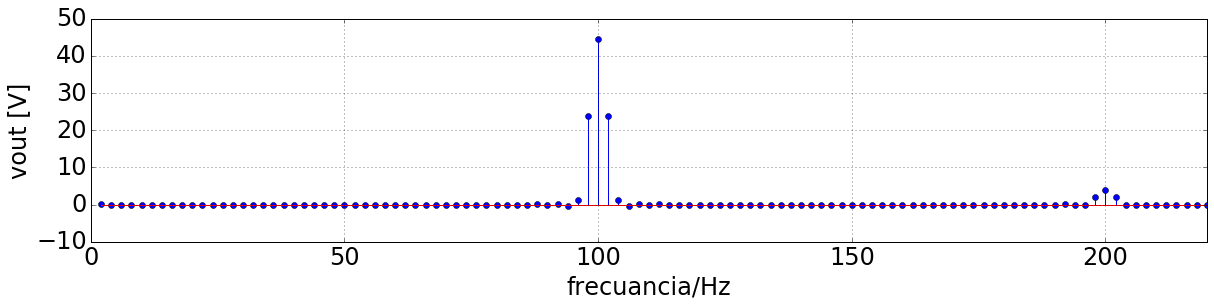

In [284]:
#calculo de la transferencia del filtro
vout_f = dict()
for x,i in enumerate(ids_mf[1:]):
    vout_f[armonicos[x+1]]= (SS(i*RL,armonicos[x+1],Qc,fo))
    
plt.stem(armonicos[1:],[vout_f[a] for a in armonicos[1:]] ) 
plt.xlabel('frecuancia/Hz')
plt.ylabel('vout [V]')
plt.grid()
plt.xlim([0,220])

print('Vo(98) ={:.2f} V, Vo(100) ={:.2f} V,Vo(102) ={:.2f} V'.format(vout_f[98],vout_f[100],vout_f[102]) )
pinf = vout_f[98]**2/2/RL
pcar = vout_f[100]**2/2/RL
psup = vout_f[102]**2/2/RL
ptot = pinf + pcar + psup

print('Pinf ={:.2f} W, Pcar ={:.2f} W, Psup ={:.2f} W'.format(pinf,pcar,psup) )
print('PAM ={:.2f} W'.format(ptot) )


Ahora el mismo analisis de la senal de salida pero por el metodo de trapecios. 
Calculo de primer armonico y continua de la portadora cada 360/n grados de la modulante

In [285]:
n    = 24
th_c = np.arange(-np.pi,np.pi,2*np.pi/n)
th_m = np.arange(-np.pi,np.pi,2*np.pi/n)

In [286]:
ieff  = dict()
ids_f = dict() # corriente de salida
comp  = [0,1,2,3,4,5,6,7]

for t_m in th_m: # cada 360/n grados de la modulante
    ids = list()    
    # obtiene la corriente de la portadora para la condición de la portadora dada:
    for t_c in th_c: # cada 360/n grados de la portadora
        vm  =  np.cos(t_m)
        vam = amp*(1+m*(vm))*np.cos(t_c)
        vgs = (VGG+vam) 
        ids.append(idi(vgs))

    ieff[t_m] = eff(ids) # corriente eficaz
    # con la corriente obtiene los armonicos del pulso de la portadora
    for a in comp: # calculo DC y 7 armonicos 
        if a not in ids_f : ids_f[a] = dict()
        if t_m not in ids_f[a] : 
            ids_f[a][t_m] = myFourierPh(a, th_c, ids, n)




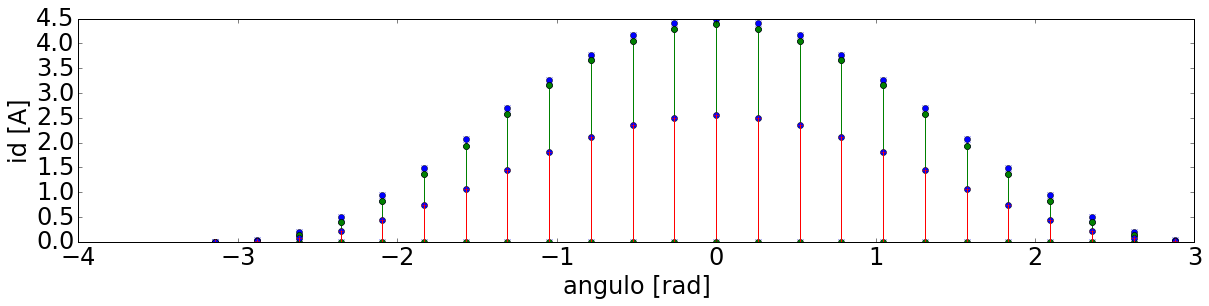

In [287]:
# eficaz
plt.stem(th_m,[ieff[t_m] for t_m in th_m] ,'b-x')
# grafica para los n casos de la modulante los valores de fundamental y DC 
plt.stem(th_m,[ids_f[1][t_m] for t_m in th_m],'g-o' )
plt.stem(th_m,[ids_f[0][t_m] for t_m in th_m] ,'r-+')

plt.xlabel('angulo [rad]')
plt.ylabel('id [A]')
#print(id1)

In [288]:
#calculo de la resistencia de carga de salida teniendo la portadora en pico para el primer armonico de la modulante
Vp  = (Vgs_max-Vgs_min)/ 2
VDD = Vp + Vgs_min
print('VDD=', VDD, 'V')
print('Vp=' , Vp, 'V')

RL = Vp /ids_f[1][th_m[12]] # th_m[12] es la condición de pico
print('RL= {:0.2f} ohms'.format(RL) )
 
    

VDD= 105.0 V
Vp= 95.0 V
RL= 21.67 ohms


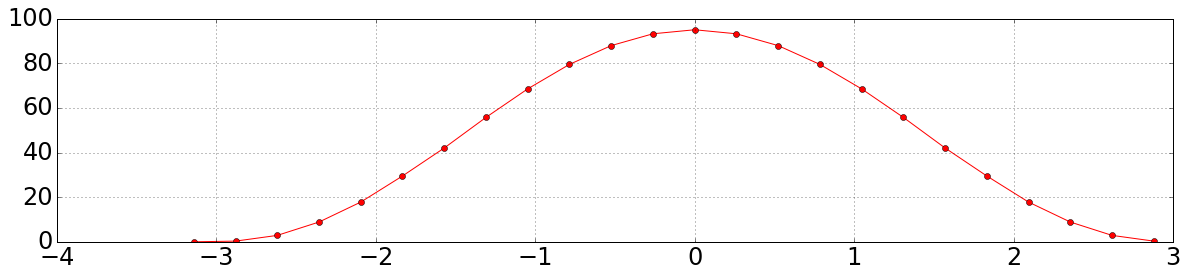

In [289]:
# Grafica de la envolvente de la señal 
vol = [ids_f[1][t]*RL for t in th_m]
plt.plot(th_m,vol ,'ro-')
plt.grid()

44.4736020974
48.8255124955
2.47923982885
-1.00627477457
0.333898657242
-0.220402426868
0.168124038754
-0.0397572523824


(-1, 7)

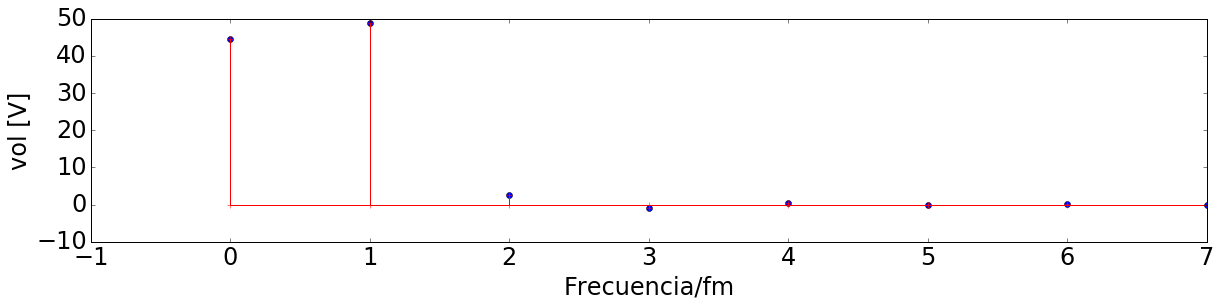

In [290]:
vol_f = dict()
for a in comp: # calculo DC y 7 armonicos 
    vol_f[a] = myFourierPh(a, th_m, vol, n)
    print(vol_f[a])

plt.stem(comp,[vol_f[a] for a in comp],'r-+')

plt.xlabel('Frecuencia/fm')
plt.ylabel('vol [V]')
plt.xlim([-1,7])
#print(id1)        

Del analisis anterior se concluye que la tensión de salida a la frecuancia de la modulante es de 48.82 V sobre una resistencia de 21 ohms.
La continua de esta señal se bloquea por el capacitor de salida.

In [291]:
# Calculo de las potencias para las distintas condiciones de modulante
idco = ids_f[0][th_m[6]]
idc1 = ids_f[1][th_m[6]]

#Poradora en condicion de Pico
idpo = ids_f[0][th_m[12]]
idp1 = ids_f[1][th_m[12]]

#Poradora en condicion de valle
idvo = ids_f[0][th_m[0]]
idv1 = ids_f[1][th_m[0]]

print('Corriente Portadora =>  idco={:0.2f}A,idc1={:0.2f}A'.format(idco, idc1) )
print('Corriente Pico      =>  idco={:0.2f}A,idc1={:0.2f}A'.format(idpo, idp1) )
print('Corriente Valle     =>  idco={:0.2f}A,idc1={:0.2f}A'.format(idvo, idv1) )



Corriente Portadora =>  idco=1.07A,idc1=1.94A
Corriente Pico      =>  idco=2.55A,idc1=4.38A
Corriente Valle     =>  idco=0.00A,idc1=0.00A


In [292]:
def SS(vin,f, Qc, fo):
    return vin*abs(1/(1+(Qc*(f/fo-fo/f))**2)**0.5)

23.9222441205 44.4884154859 23.940849088


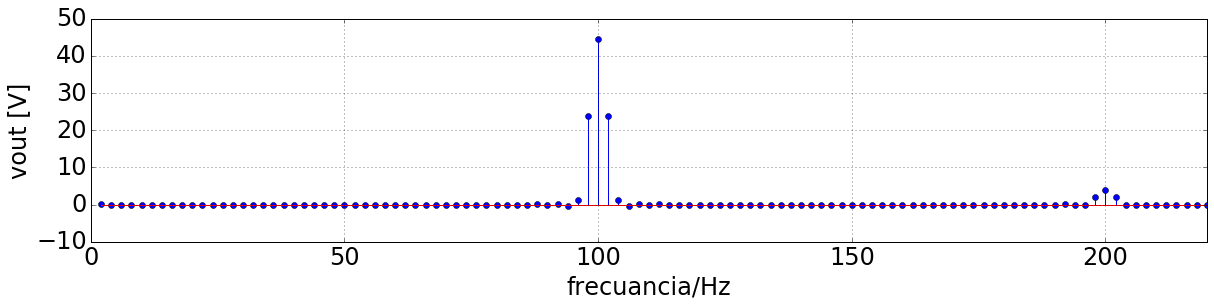

In [293]:
#calculo de la transferencia del filtro
vout_f = []
for x,i in enumerate(ids_mf[1:]):
    vout_f.append(SS(i*RL,armonicos[x+1],Qc,fo))
    
plt.stem(armonicos[1:],vout_f[:]) 
plt.xlabel('frecuancia/Hz')
plt.ylabel('vout [V]')
plt.grid()
plt.xlim([0,220])
print(vout_f[48],vout_f[49],vout_f[50])



In [294]:
#Portadora
PDC_c = idco * VDD
PRL_c = idc1 * Vp / 2
PTR_c = PDC_c - PRL_c

#Portadora en pico 
PDC_p = idpo * VDD
PRL_p = idp1 * Vp / 2
PTR_p = PDC_p - PRL_p
#Portadora en valle 
PDC_v = idvo * VDD
PRL_v = idv1 * Vp / 2
PTR_v = PDC_v - PRL_v


print('Pot portadora => PDC ={:3.2f}W, PRL={:3.2f}W, PTR={:3.2f}W'.format(PDC_c,PRL_c,PTR_c) )
print('Pot pico      => PDC ={:3.2f}W, PRL={:3.2f}W, PTR={:3.2f}W'.format(PDC_p,PRL_p,PTR_p) )
print('Pot valle     => PDC ={:3.2f}W, PRL={:3.2f}W, PTR={:3.2f}W'.format(PDC_v,PRL_v,PTR_v) )


pot_inf = vout_f[48]**2/2/RL
pot     = vout_f[49]**2/2/RL
pot_sup = vout_f[50]**2/2/RL
print('Pot total = {:3.2f} + {:3.2f} + {:3.2f} = {:3.2f}W '.format(pot_inf,pot,pot_sup, pot_inf+pot+pot_sup ))

Pot portadora => PDC =112.79W, PRL=92.11W, PTR=20.68W
Pot pico      => PDC =267.63W, PRL=208.21W, PTR=59.42W
Pot valle     => PDC =0.00W, PRL=0.00W, PTR=0.00W
Pot total = 13.20 + 45.66 + 13.22 = 72.09W 
